[*********************100%%**********************]  1 of 1 completed


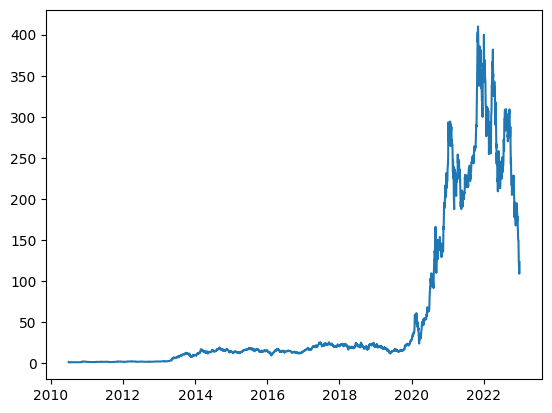

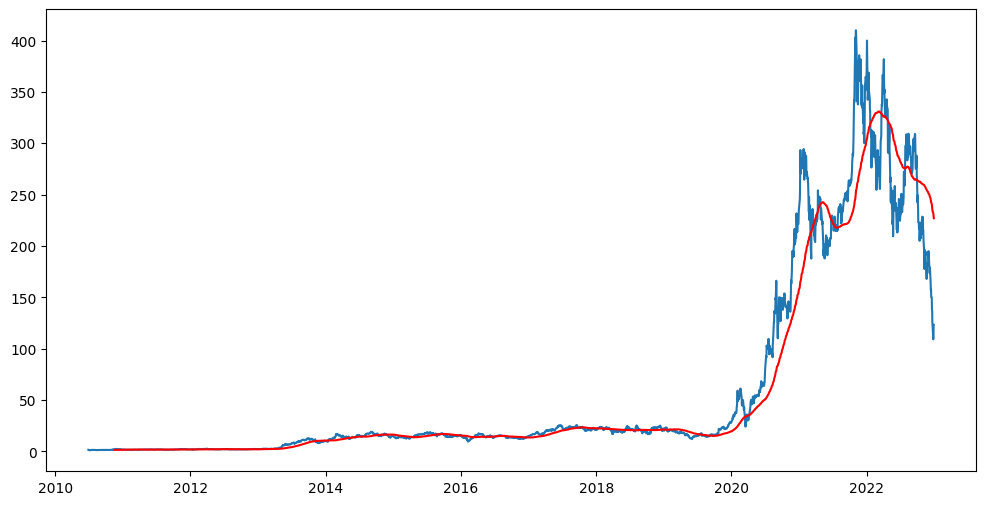

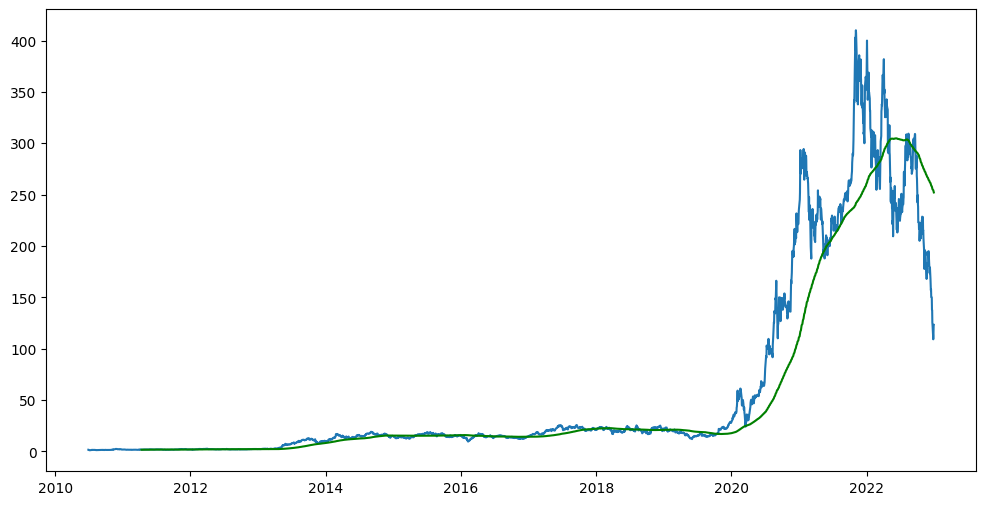

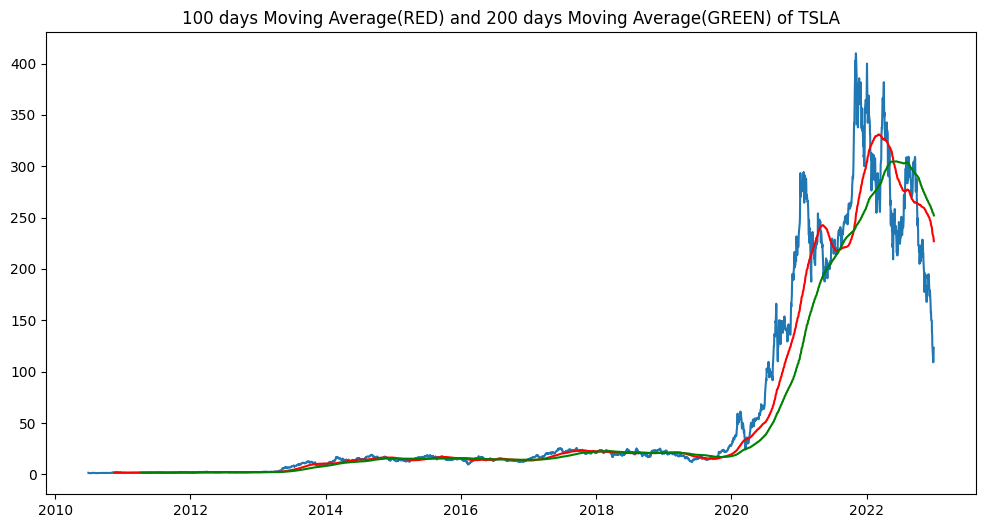

In [44]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt 
import yfinance as yf
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Load Data
company = 'TSLA'
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2023, 1, 1)

data = yf.download(company, start=start, end=end)

# Plot Closing Prices
plt.plot(data['Close'])
plt.show()

# Calculate 100 days moving average
ma100 = data['Close'].rolling(100).mean()

# Plot Closing Prices with 100 days moving average
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.plot(ma100, 'r')
plt.show()

# Calculate 200 days moving average
ma200 = data['Close'].rolling(200).mean()

# Plot Closing Prices with 200 days moving average
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.plot(ma200, 'g')
plt.show()

# Plot Closing Prices with 100 and 200 days moving averages
plt.figure(figsize=(12, 6))
plt.title(f"100 days Moving Average(RED) and 200 days Moving Average(GREEN) of {company}")
plt.plot(data['Close'])
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.show()

# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [45]:
#Build The Model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)






Epoch 1/25
97/97 [==============================] - 8s 39ms/step - loss: 0.0075
Epoch 2/25
97/97 [==============================] - 5s 49ms/step - loss: 0.0019
Epoch 3/25
97/97 [==============================] - 4s 41ms/step - loss: 0.0016
Epoch 4/25
97/97 [==============================] - 4s 39ms/step - loss: 0.0016
Epoch 5/25
97/97 [==============================] - 4s 40ms/step - loss: 0.0015
Epoch 6/25
97/97 [==============================] - 4s 40ms/step - loss: 0.0014
Epoch 7/25
97/97 [==============================] - 4s 40ms/step - loss: 0.0013
Epoch 8/25
97/97 [==============================] - 4s 43ms/step - loss: 0.0013
Epoch 9/25
97/97 [==============================] - 4s 46ms/step - loss: 0.0011
Epoch 10/25
97/97 [==============================] - 5s 51ms/step - loss: 0.0012
Epoch 11/25
97/97 [==============================] - 5s 52ms/step - loss: 0.0011
Epoch 12/25
97/97 [==============================] - 5s 51ms/step - loss: 0.0012
Epoch 13/25
97/97 [==================

In [46]:
# Save the model in the native Keras format 
model.save('my_model.h5')  

[*********************100%%**********************]  1 of 1 completed
[[[0.57976769]
  [0.54293868]
  [0.54266967]
  ...
  [0.27305482]
  [0.2953332 ]
  [0.29865906]]

 [[0.54293868]
  [0.54266967]
  [0.52687181]
  ...
  [0.2953332 ]
  [0.29865906]
  [0.97543916]]

 [[0.54266967]
  [0.52687181]
  [0.52868149]
  ...
  [0.29865906]
  [0.97543916]
  [0.93452616]]

 ...

 [[0.61657222]
  [0.60507845]
  [0.60493172]
  ...
  [0.420053  ]
  [0.41518647]
  [0.41958835]]

 [[0.60507845]
  [0.60493172]
  [0.58055023]
  ...
  [0.41518647]
  [0.41958835]
  [0.43191359]]

 [[0.60493172]
  [0.58055023]
  [0.57927856]
  ...
  [0.41958835]
  [0.43191359]
  [0.43719585]]]
18/18 [==============================] - 1s 11ms/step
Mean Squared Error (MSE): 444.04536734083234
Root Mean Squared Error (RMSE): 21.072383997564973
Mean Absolute Error (MAE): 11.249431813738948


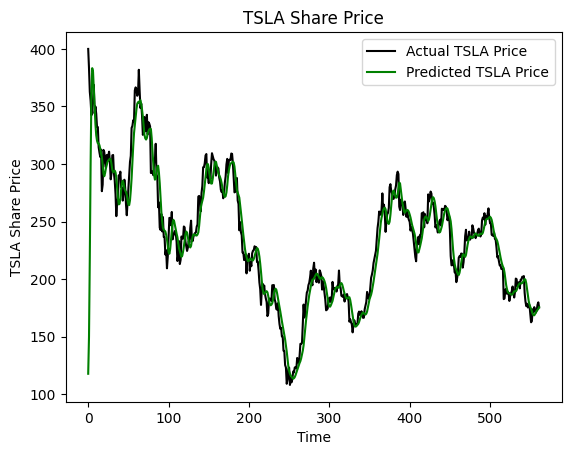

1/1 [==============================] - 0s 28ms/step
Prediction of Next Day: [[176.58179]]


In [47]:




# Test the model accuracy on the Existing Data

# Load Test Data
test_start = dt.datetime(2022, 1, 1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Make prediction on Test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test)
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot the test predictions
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

# Predict Next Day

# Predict Next Day
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction of Next Day: {prediction}")

# # Define the actual prices for the next day
# actual_price_next_day_lstm = test_data['Close'].iloc[-1]

# # Calculate MAE
# mae_lstm = mean_absolute_error([actual_price_next_day_lstm], prediction)
# print("Mean Absolute Error (MAE):", mae_lstm)



In [48]:
# Implementing Arima model to compare the performance 
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

tomorrow = test_end + dt.timedelta(days=1)
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(test_data['Close'], trace=True, suppress_warnings=True)
stepwise_fit.summary()



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4019.835, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4039.348, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4041.030, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4041.046, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4038.500, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4041.334, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4041.662, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4021.747, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4040.781, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4037.194, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4040.999, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4023.362, Time=0.58 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4018.961, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  562
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2004.480
Date:                Fri, 29 Mar 2024   AIC                           4018.961
Time:                        01:08:32   BIC                           4040.609
Sample:                             0   HQIC                          4027.413
                                - 562                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5328      0.068    -22.475      0.000      -1.666      -1.399
ar.L2         -0.7794      0.065    -11.976      0.000      -0.907      -0.652
ma.L1          1.5592      0.057     27.167      0.000       1.447       1.672
ma.L2          0.8727      0.052     16.819      0.000       0.771       0.974
sigma2        74.2570      3.618     20.526      0.000      67.166      81.348
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                41.89
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
model = ARIMA(test_data['Close'],order=(2,1,2))
fitted = model.fit()
print(fitted.summary())

#predicting the next day prices
next_day_price = fitted.forecast (100,alpha=0.05) #(we can predict upto 100 days with alpha = 0.05 95% confidence level of tommorow predicted prices)
print(next_day_price)


predicted_price = next_day_price.values[0]
print(f"The predicted price for {tomorrow} tomorrow:", predicted_price)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  562
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2004.480
Date:                Fri, 29 Mar 2024   AIC                           4018.961
Time:                        01:08:32   BIC                           4040.609
Sample:                             0   HQIC                          4027.413
                                - 562                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5328      0.068    -22.475      0.000      -1.666      -1.399
ar.L2         -0.7794      0.065    -11.976      0.000      -0.907      -0.652
ma.L1          1.5592      0.057     27.167      0.0

In [50]:
from sklearn.metrics import mean_absolute_error
# Forecasting with ARIMA model
forecasted_prices_arima = fitted.forecast(len(test_data))

# Calculate MAE for ARIMA model
mae_arima = mean_absolute_error(test_data['Close'], forecasted_prices_arima)

# Print MAE for both models
print(f"Mean Absolute Error (MAE) - LSTM: {mae}")
print(f"Mean Absolute Error (MAE) - ARIMA: {mae_arima}")

# Compare MAE values
if mae < mae_arima:
    print("LSTM model performs better.")
elif mae > mae_arima:
    print("ARIMA model performs better.")
else:
    print("Both models perform equally well.")

Mean Absolute Error (MAE) - LSTM: 11.249431813738948
Mean Absolute Error (MAE) - ARIMA: 65.79115892323757
LSTM model performs better.


In [51]:
# # Calculating MAE for next day price
# # Importing mean_absolute_error from sklearn.metrics
# from sklearn.metrics import mean_absolute_error

# # Define the actual prices for the next day
# actual_price_next_day = test_data['Close'].iloc[-1]

# # Calculate MAE
# mae_arima = mean_absolute_error([actual_price_next_day], [predicted_price])
# print("Mean Absolute Error (MAE):", mae_arima)

# #  Print MAE for both models
# print(f"Mean Absolute Error (MAE) - LSTM: {mae_lstm}")
# print(f"Mean Absolute Error (MAE) - ARIMA: {mae_arima}")

# # Compare MAE values
# if mae_lstm < mae_arima:
#     print("LSTM model performs better.")
# elif mae_lstm > mae_arima:
#     print("ARIMA model performs better.")
# else:
#     print("Both models perform equally well.")

In [52]:

model_mae_scores = {'LSTM':mae, 'ARIMA':mae_arima}
model_mae_scores


{'LSTM': 11.249431813738948, 'ARIMA': 65.79115892323757}

In [56]:
model_mae_scores['LSTM'] = 11.249431813738948
model_mae_scores['ARIMA'] = 65.79115892323757

In [57]:
# Store MAE scores
%store model_mae_scores

%store -r model_mae_scores
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

Stored 'model_mae_scores' (dict)


Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

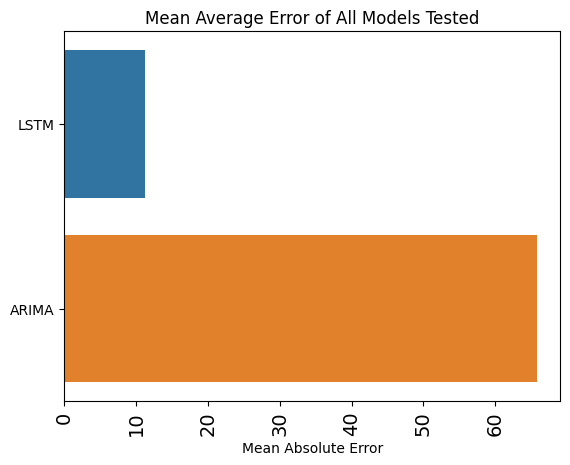

In [58]:
import seaborn as sns
# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')